In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.cluster import KMeans
import seaborn as sns

class LaplacianMixtureModel:
    def __init__(self, n_components=10, max_iter=30, tol=1e-4, verbose=True):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _laplace_log_pdf(self, x, mu, b):
        return -np.log(2 * b + 1e-10) - np.abs(x - mu) / (b + 1e-10)

    def _e_step(self, X):
        N, D = X.shape
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        max_log_resp = np.max(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp - max_log_resp)
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N

        for k in range(self.K):
            mu_k = np.zeros(D)
            for d in range(D):
                sorted_idx = np.argsort(X[:, d])
                sorted_X = X[sorted_idx, d]
                sorted_weights = resp[sorted_idx, k]
                cum_weights = np.cumsum(sorted_weights)
                median_idx = np.searchsorted(cum_weights, Nk[k] / 2)
                mu_k[d] = sorted_X[median_idx]
            self.mu[k] = mu_k
            self.b[k] = np.sum(resp[:, k][:, None] * np.abs(X - self.mu[k]), axis=0) / Nk[k]
            self.b[k] = np.clip(self.b[k], 1e-3, None)

    def fit(self, X):
        N, D = X.shape
        km = KMeans(n_clusters=self.K, init='k-means++', n_init=10).fit(X)
        self.mu = km.cluster_centers_
        self.b = np.ones((self.K, D))
        self.pi = np.ones(self.K) / self.K
        self.loss_history = []

        progress = trange(self.max_iter, desc="Training LMM", leave=True)
        for i in progress:
            resp = self._e_step(X)
            self._m_step(X, resp)

            if self.verbose:
                log_likelihood = np.sum(np.log(np.sum([
                    self.pi[k] * np.exp(np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1))
                    for k in range(self.K)
                ], axis=0) + 1e-10))
                progress.set_description(f"Iter {i+1} | LogL: {log_likelihood:.2f}")
                self.loss_history.append(log_likelihood)

        self.resp = resp

    def predict(self, X):
        log_resp = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        return np.argmax(log_resp, axis=1)
    
    def sample(self, n_samples=10):
        samples = []
        component_ids = np.random.choice(self.K, size=n_samples, p=self.pi)

        for k in component_ids:
            mu_k = self.mu[k]
            b_k = self.b[k]

            # Sample from Laplace using inverse transform sampling
            u = np.random.uniform(low=-0.5, high=0.5, size=mu_k.shape)
            x = mu_k - b_k * np.sign(u) * np.log(1 - 2 * np.abs(u))
            samples.append(x)

        return np.array(samples), component_ids

    def plot_components(self, pca):
        imgs = pca.inverse_transform(self.mu)
        n_cols = 10
        n_rows = (self.K + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1 * n_cols, 1 * n_rows))
        axes = axes.flatten()

        for k in range(self.K):
            axes[k].imshow(imgs[k].reshape(28, 28), cmap='gray')
            axes[k].axis('off')

        for k in range(self.K, len(axes)):
            axes[k].axis('off')

        plt.suptitle("LMM Component Means", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

    def plot_loss(self, figsize=(10, 5)):
        plt.figure(figsize=figsize)
        plt.plot(self.loss_history)
        plt.title("Log-Likelihood Loss History")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid()
        plt.show()

In [4]:
# Load MNIST
mnist = fetch_openml("mnist_784", version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)

# Subset and PCA
train_samples = 20000
test_samples = 10000

X_train = X[:train_samples]
y_train = y[:train_samples]
X_test = X[train_samples:train_samples + test_samples]
y_test = y[train_samples:train_samples + test_samples]

pca = PCA(n_components=50, whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Iter 50 | LogL: -457699.96: 100%|██████████| 50/50 [02:34<00:00,  3.08s/it]



Mapped Clustering Accuracy: 76.75%


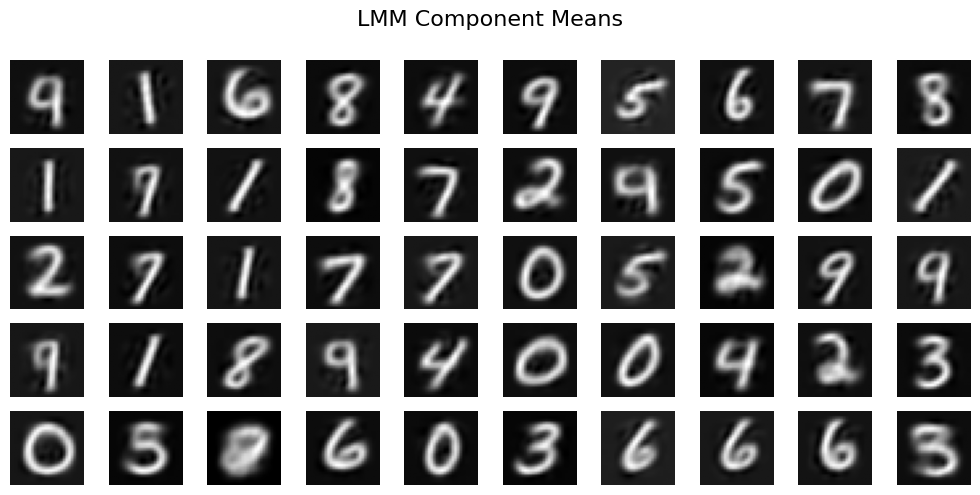

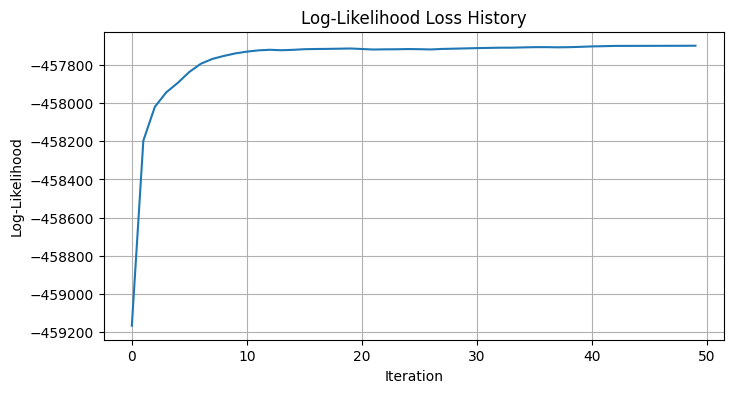

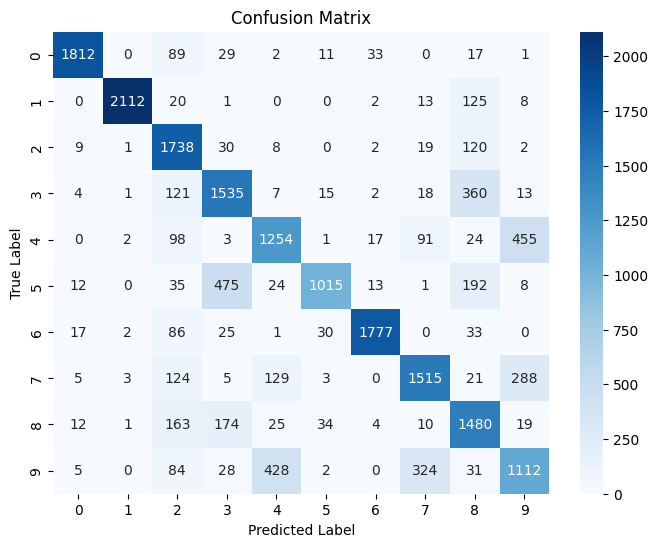

In [5]:
# Train LMM
lmm = LaplacianMixtureModel(n_components=50, max_iter=50, verbose=True)
lmm.fit(X_train_pca)

# Predict clusters
y_pred = lmm.predict(X_train_pca)

# Simple mode mapping
label_map = {}
for k in range(lmm.K):
    cluster_points = y_train[y_pred == k]
    if len(cluster_points) > 0:
        most_common = mode(cluster_points, keepdims=False).mode
        label_map[k] = int(most_common)
    else:
        label_map[k] = -1
mapped_preds = np.array([label_map.get(cluster, -1) for cluster in y_pred])

# Accuracy
accuracy = accuracy_score(y_train, mapped_preds)
print(f"\nMapped Clustering Accuracy: {accuracy * 100:.2f}%")

# Visualize components and loss
lmm.plot_components(pca)
lmm.plot_loss((8, 4))

# Compute the confusion matrix
conf_mat = confusion_matrix(y_train, mapped_preds, labels=np.arange(10))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Training LMM: 100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


Ensemble LMM Accuracy: 0.0629


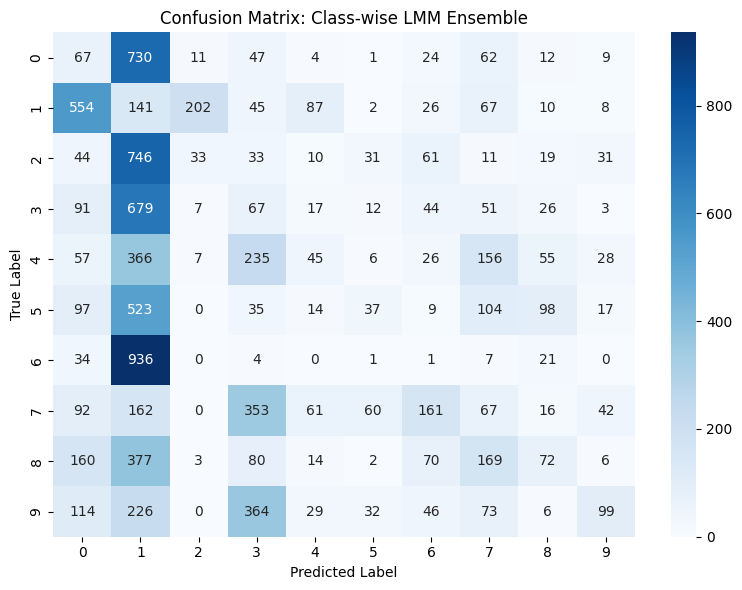

In [ ]:
# Configuration
n_components = 5  # Number of Gaussians per class
num_classes = 10  # Digits 0 to 9

# Step 1: Train one LMM per class
lmm_models = {}
for digit in range(num_classes):
    # Extract samples of the current digit
    X_class = X_train[y_train == digit].values  # Ensure we work with numpy array data
    
    # Train LMM for this class
    lmm = LaplacianMixtureModel(n_components=n_components, max_iter=10, verbose=False)
    lmm.fit(X_class)
    
    lmm_models[digit] = lmm

# Step 2: Predict labels for test data based on maximum likelihood across class-LMMs
log_likelihoods = np.zeros((len(X_test), num_classes))  # shape: [num_samples, num_classes]

for digit, lmm in lmm_models.items():
    log_likelihoods[:, digit] = lmm.predict(X_test)  # Get predicted class for each test sample

# Assign label with highest log-likelihood
y_pred = np.argmax(log_likelihoods, axis=1)

# Step 3: Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"Ensemble LMM Accuracy: {acc:.4f}")

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: Class-wise LMM Ensemble')
plt.tight_layout()
plt.show()
